# Синхронизация с гит

In [1]:
# --- БЛОК №1: НАЧАЛО РАБОТЫ (выполнять в каждой новой сессии) ---

from google.colab import drive, userdata
import os

# 1. Монтируем Google Drive
drive.mount('/content/drive')

# 2. Получаем секретный токен
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')

# 3. Указываем ваше имя и email (как на GitHub)
GIT_USERNAME = "kirichich1" # <-- Ваше имя пользователя
GIT_EMAIL = "kirichich@bk.ru" # <-- Ваша почта

# 4. !!! ПРЕДСТАВЛЯЕМСЯ СИСТЕМЕ GIT !!!
# Эта конфигурация будет действовать до конца текущей сессии
!git config --global user.name "{GIT_USERNAME}"
!git config --global user.email "{GIT_EMAIL}"

# 5. Переходим в директорию проекта
PROJECT_PATH = "/content/drive/MyDrive/GitHub/no2_prediction_pipeline"
%cd {PROJECT_PATH}

# 6. (Рекомендуется) Скачиваем последние изменения с GitHub на случай, если вы работали с другого устройства
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/no2_prediction_pipeline
Already up to date.


# Импорт библиотек и загрузка данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
file_path = '/content/drive/MyDrive/GitHub/no2_prediction_pipeline/data/processed/Surgut_data_2019_to_2024_COMBINED_WITH_AAI.csv'

In [4]:
df = pd.read_csv(file_path)

# Начальная очистка и подготовка данных

In [5]:
# --- Начальная очистка и подготовка данных (ИСПРАВЛЕННАЯ ВЕРСИЯ) ---

# Преобразуем колонку 'date' в формат datetime для дальнейшей работы
df['date'] = pd.to_datetime(df['date'])

# Создаем целевую переменную и удаляем дубликат, если необходимо
if 'no2_umol_m2' not in df.columns:
    df['no2_umol_m2'] = df['no2_trop_mean'] * 1e6
if 'no2_trop_mean' in df.columns:
    df = df.drop('no2_trop_mean', axis=1)

# Заполняем редкие пропуски в признаках
# Важно: Сначала заполняем пропуски в исходном df
median_cloud = df['cloud_frac_mean'].median()
df['cloud_frac_mean'].fillna(median_cloud, inplace=True)

# !!! Ключевой шаг: работаем только с реальными данными NO2
### ИЗМЕНЕНИЕ ЗДЕСЬ: добавили .copy() ###
df_processed = df.dropna(subset=['no2_umol_m2']).copy()

print(f"Количество строк после удаления пропусков в NO2: {len(df_processed)}")

Количество строк после удаления пропусков в NO2: 877


/tmp/ipython-input-4112952202.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cloud_frac_mean'].fillna(median_cloud, inplace=True)


# Feature Engineering

In [6]:
# --- Feature Engineering (ВЕРСИЯ: Winter Interaction) ---

# --- ШАГ 3.1: Базовые признаки ---
print("Создание базовых признаков...")
df_processed['year'] = df_processed['date'].dt.year

# Вектор ветра
df_processed['wind_speed'] = np.sqrt(df_processed['u_wind_10m']**2 + df_processed['v_wind_10m']**2)
df_processed['wind_direction'] = (270 - np.arctan2(df_processed['v_wind_10m'], df_processed['u_wind_10m']) * 180 / np.pi) % 360

# Календарь
df_processed['month'] = df_processed['date'].dt.month
df_processed['day_of_year'] = df_processed['date'].dt.dayofyear
df_processed['day_of_week'] = df_processed['date'].dt.dayofweek
df_processed['week_of_year'] = df_processed['date'].dt.isocalendar().week.astype(int)

# --- ФИЗИЧЕСКИЕ ПРИЗНАКИ ---

# 1. HDD (Нагрузка на отопление)
df_processed['HDD'] = (18 - df_processed['temperature_celsius']).clip(lower=0)

# 2. Индекс Застоя (Stagnation)
df_processed['stagnation_index'] = df_processed['pressure_hpa'] / (df_processed['wind_speed'] + 0.1)

# 3. !!! НОВОЕ: Зимняя ловушка (Взаимодействие холода и застоя) !!!
# Чем холоднее (высокий HDD) И чем сильнее застой, тем выше этот коэффициент.
df_processed['winter_stagnation'] = df_processed['HDD'] * df_processed['stagnation_index']

# --- ШАГ 3.2: Лаги и Тренды ---
print("\nСоздание лагов и скользящих средних...")
df_processed = df_processed.sort_values(by='date')
grouped = df_processed.groupby('year')

# Лаги
df_processed['no2_lag_1'] = grouped['no2_umol_m2'].shift(1)
df_processed['wind_speed_lag_1'] = grouped['wind_speed'].shift(1)
df_processed['temperature_lag_1'] = grouped['temperature_celsius'].shift(1)
df_processed['aai_lag_1'] = grouped['aai_mean'].shift(1)

# Скользящие средние
df_processed['no2_roll_mean_3'] = grouped['no2_umol_m2'].shift(1).rolling(window=3).mean()
df_processed['no2_roll_mean_7'] = grouped['no2_umol_m2'].shift(1).rolling(window=7).mean()
df_processed['wind_roll_mean_3'] = grouped['wind_speed'].shift(1).rolling(window=3).mean()

# Delta Wind
df_processed['delta_wind'] = df_processed['wind_speed'] - df_processed['wind_speed_lag_1']

# --- ШАГ 3.3: Очистка ---
initial_rows = len(df_processed)
roll_columns = ['no2_roll_mean_3', 'no2_roll_mean_7', 'wind_roll_mean_3', 'no2_lag_1']
df_processed.dropna(subset=roll_columns, inplace=True)

print(f"Итоговое количество строк: {len(df_processed)}")

Создание базовых признаков...

Создание лагов и скользящих средних...
Итоговое количество строк: 835


# Разделение данных на обучающую и тестовую выборки

In [7]:
# Обучаемся на всех данных ДО 2024 года
train_data = df_processed[df_processed['year'] < 2024]
# Тестируем на ПОЛНОМ 2024 годе
test_data = df_processed[df_processed['year'] == 2024]

In [8]:
print(f"\nРазмер обучающей выборки (2019-2023): {len(train_data)} строк")
print(f"Размер тестовой выборки (2024): {len(test_data)} строк")


Размер обучающей выборки (2019-2023): 677 строк
Размер тестовой выборки (2024): 158 строк


# Определение признаков (X) и целевой переменной (y)

In [9]:
# --- ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ (ВЕРСИЯ: Без логарифма, Без облаков, С физикой) ---
train_data = df_processed[df_processed['year'] < 2024]
test_data = df_processed[df_processed['year'] == 2024]

# ВОЗВРАЩАЕМ ОБЫЧНУЮ ЦЕЛЕВУЮ ПЕРЕМЕННУЮ
# (clip(0) оставляем на всякий случай, чтобы убрать шум, но не логарифмируем)
y_train = train_data['no2_umol_m2'].clip(lower=0)
y_test = test_data['no2_umol_m2']
dates_test = test_data['date']

features = [
    # Метеорология (БЕЗ cloud_frac_mean)
    'temperature_celsius', 'pressure_hpa',
    'wind_speed', 'wind_direction', 'aai_mean',
    'month', 'day_of_year', 'day_of_week', 'week_of_year',

    # Физика
    'HDD',
    'stagnation_index',
    'winter_stagnation',  # Оставляем, дадим шанс без логарифма
    'delta_wind',

    # Лаги и Тренды
    'no2_lag_1', 'wind_speed_lag_1', 'temperature_lag_1', 'aai_lag_1',
    'no2_roll_mean_3', 'no2_roll_mean_7', 'wind_roll_mean_3'
]

X_train = train_data[features]
X_test = test_data[features]

Размер y_train_log: 677
Количество NaN в y_train_log: 0


# Инициализация и обучение модели RandomForestRegressor

In [10]:
# --- ОБУЧЕНИЕ МОДЕЛИ ---
# Увеличиваем количество деревьев до 500 для стабильности
print(f"\nОбучение модели (n_estimators=500) на {len(features)} признаках...")
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, oob_score=True)

model.fit(X_train, y_train)
print("Модель обучена.")
print(f"OOB Score (R^2 на трейне): {model.oob_score_:.3f}")

# --- ПРЕДСКАЗАНИЕ ---
y_pred = model.predict(X_test)

# --- ОЦЕНКА ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Оценка качества (Без облаков, Без Log) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")


Обучение модели на log(NO2)...
Модель обучена.


# Предсказание и оценка качества модели

In [11]:
# Получаем предсказание в логарифмах
y_pred_log = model.predict(X_test)

# !!! ВАЖНО: Возвращаем предсказания в обычный масштаб (экспонента) !!!
y_pred = np.expm1(y_pred_log)

# --- ОЦЕНКА ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Оценка качества (с Log-transform) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")


--- Оценка качества (с Log-transform) ---
MAE: 11.30
RMSE: 19.22
R^2: 0.286


# Визуализация результатов

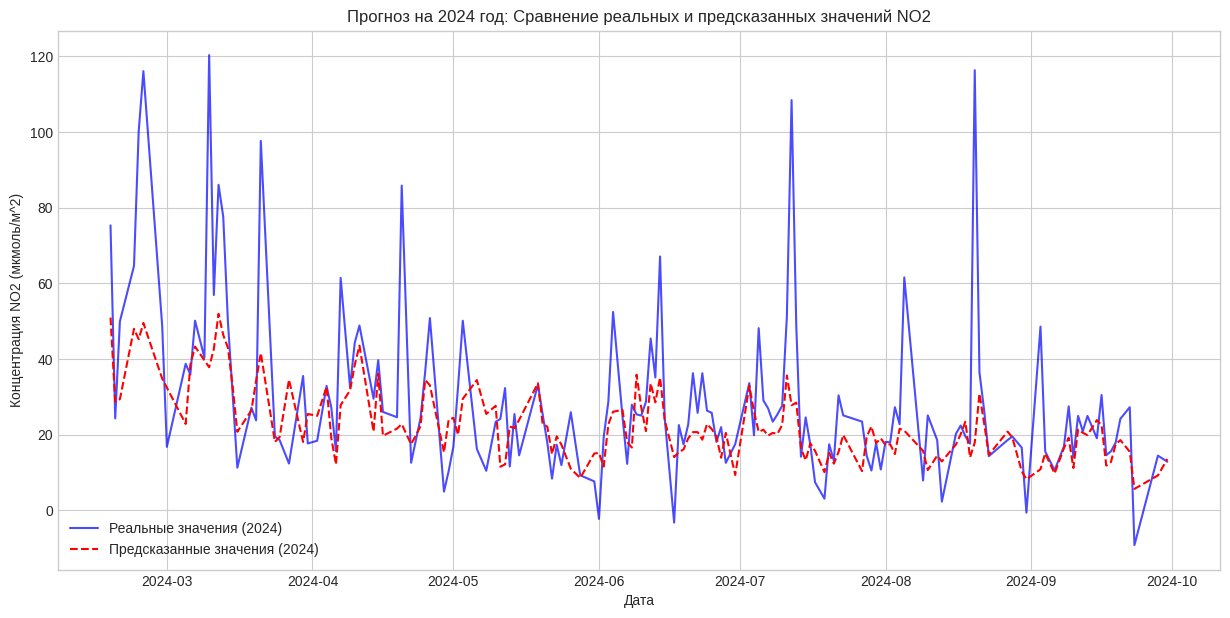

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))
plt.plot(dates_test, y_test.values, label='Реальные значения (2024)', color='blue', alpha=0.7)
plt.plot(dates_test, y_pred, label='Предсказанные значения (2024)', color='red', linestyle='--')
plt.title('Прогноз на 2024 год: Сравнение реальных и предсказанных значений NO2')
plt.xlabel('Дата')
plt.ylabel('Концентрация NO2 (мкмоль/м^2)')
plt.legend()
plt.show()

# Анализ важности признаков

In [13]:
feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

print("\n--- Важность признаков для модели ---")
print(feature_importances)


--- Важность признаков для модели ---
                     importance
cloud_frac_mean        0.144462
stagnation_index       0.082815
wind_direction         0.079028
no2_roll_mean_3        0.077545
no2_lag_1              0.066373
day_of_year            0.052307
winter_stagnation      0.051702
temperature_lag_1      0.049819
pressure_hpa           0.048153
aai_lag_1              0.047985
wind_speed             0.047741
no2_roll_mean_7        0.042572
delta_wind             0.039354
aai_mean               0.033264
wind_speed_lag_1       0.032918
wind_roll_mean_3       0.025973
temperature_celsius    0.020915
week_of_year           0.020540
HDD                    0.016836
day_of_week            0.015335
month                  0.004360


In [14]:
df[df['no2_umol_m2'] > 100]

,date,city,aai_mean,cloud_frac_mean,temperature_celsius,pressure_hpa,u_wind_10m,v_wind_10m,no2_umol_m2
1011,2023-03-15,Surgut,-0.562642,0.166187,-4.943197,1013.720262,0.749265,0.207934,119.171054
1027,2023-03-31,Surgut,-0.766885,0.476933,-7.996818,1032.304811,-0.514054,3.000888,125.578127
1223,2024-02-13,Surgut,-0.620729,0.181614,-29.456923,1014.448276,-1.831588,-1.563105,145.447044
1234,2024-02-24,Surgut,-0.614109,0.145870,-14.053541,1020.380120,-0.533383,1.592961,100.173522
1235,2024-02-25,Surgut,-0.538206,0.326355,-12.183362,1022.510539,-1.899673,2.154136,116.085175
1249,2024-03-10,Surgut,-0.293070,0.411189,-17.421679,1005.675419,0.777507,-2.078481,120.331177
1373,2024-07-12,Surgut,-0.847207,0.127651,22.823486,1001.741263,0.112469,-1.782524,108.427293
1412,2024-08-20,Surgut,-1.059317,0.316674,15.989474,999.341421,0.511697,-0.828627,116.337921


# Коммит для гит

In [15]:
# --- БЛОК №2: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ (в конце работы) ---

# 1. Проверяем статус (опционально)
!git status

# 2. ДОБАВЛЯЕМ файлы в "коробку" для отправки. Это то, что вы пропустили.
!git add .

# 3. ПОДПИСЫВАЕМ "коробку" (делаем коммит)
!git commit -m "Add winter_stagnation interaction and use Log-Target transformation"

# 4. ОТПРАВЛЯЕМ "коробку" на GitHub
!git push

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   notebooks/RandomForestRegressor_Surgut_AAI_and_lag.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
[main 54123d1] Add winter_stagnation interaction and use Log-Target transformation
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/RandomForestRegressor_Surgut_AAI_and_lag.ipynb (99%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.82 KiB | 132.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/kirichich1/no2_prediction_pipeline.git
   cac5667..54123d1  main -> main
